In [27]:
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modcods.util.modulation as md
import modcods.util.maee as maee

np.random.seed(seed=11231512)

In [28]:
modcod_df = pd.read_excel('modcods_dvbs2.xlsx', index_col='acm')

print(modcod_df)

    order_name  order   rate                label         label_string  isend  \
acm                                                                             
0         QPSK      2   1/4      DVB-S2 QPSK 1/4      DVB_S2_QPSK_1r4   -2.35   
1         QPSK      2   1/3      DVB-S2 QPSK 1/3      DVB_S2_QPSK_1r3   -1.24   
2         QPSK      2   2/5      DVB-S2 QPSK 2/5      DVB_S2_QPSK_2r5   -0.30   
3         QPSK      2   1/2      DVB-S2 QPSK 1/2      DVB_S2_QPSK_1r2    1.00   
4         QPSK      2   3/5      DVB-S2 QPSK 3/5      DVB_S2_QPSK_3r5    2.23   
5         QPSK      2   2/3      DVB-S2 QPSK 2/3      DVB_S2_QPSK_2r3    3.10   
6         QPSK      2   3/4      DVB-S2 QPSK 3/4      DVB_S2_QPSK_3r4    4.03   
7         QPSK      2   4/5      DVB-S2 QPSK 4/5      DVB_S2_QPSK_4r5    4.68   
8         QPSK      2   5/6      DVB-S2 QPSK 5/6      DVB_S2_QPSK_5r6    5.18   
9         QPSK      2   8/9      DVB-S2 QPSK 8/9      DVB_S2_QPSK_8r9    6.20   
10        QPSK      2  9/10 

In [29]:
upsample = 10

t, h_rrc = md.raised_root_cosine(upsample, 3, 0.35)

# fig, ax = plt.subplots(figsize=(8,8))
# ax.plot(t, h_rrc)

In [30]:
VkVs_list = [0.0, 0.12, 0.31, 0.43]

# Calculate maee for each VkVs
for VkVs in VkVs_list:

    a, Pdiss, gamma = maee.power_dissipation_profile(VkVs)

    if False:
        maee.plot_disspation_profile(a, Pdiss, gamma)

    max_mod_order = np.max(modcod_df['order'])
    N_sym = 100 * max_mod_order
    N_bit = N_sym * 2**max_mod_order

    bit_seq = np.random.randint(0, 2, N_bit)

    eta_maee = np.zeros(len(modcod_df))
    papr = np.zeros(len(modcod_df))
    EPD = np.zeros(len(modcod_df))

    mag_list = [None] * len(modcod_df)
    filt_sym_seq_list = [None] * len(modcod_df)

    # Generate symbols
    for i, row in modcod_df.iterrows():

        symbols, grey_mapping = md.generate_apsk_symbols(row)
        mod_order = int(np.log2(len(symbols)))

        seq_len = int((N_sym / 5) * mod_order * (2**mod_order))
        sym_seq = md.modulate(symbols, grey_mapping, bit_seq[:seq_len])
        filt_sym_seq = np.convolve(sym_seq.repeat(upsample), h_rrc)
        filt_sym_seq = filt_sym_seq / np.max(np.abs(filt_sym_seq))

        filt_sym_seq_list[i] = filt_sym_seq

    # Calculate metrics
    for i, row in modcod_df.iterrows():

        filt_sym_seq = filt_sym_seq_list[i]

        # PAPR
        papr[i] = maee.papr(filt_sym_seq)

        # MAEE
        eta_maee[i] = maee.maee(filt_sym_seq, a, Pdiss)

    modcod_df['maee_%d' % int(VkVs * 100)] = eta_maee
    modcod_df['papr'] = papr

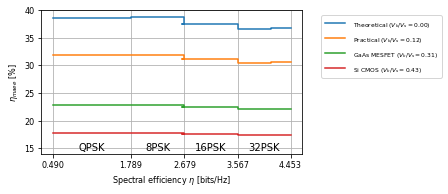

In [32]:
fig, ax = plt.subplots(1,1, figsize=(6.4, 2.4))
#modcod_df = modcod_df.sort_values('eta')

maee_label = ["Theoretical ($V_k/V_s=%.2f$)" % VkVs_list[0],
              "Practical ($V_k/V_s=%.2f$)" % VkVs_list[1],
              "GaAs MESFET ($V_k/V_s=%.2f$)" % VkVs_list[2],
              "Si CMOS ($V_k/V_s=%.2f$)" % VkVs_list[3]]

for i, VkVs in enumerate(VkVs_list):
    ax.step(modcod_df.eta, modcod_df['maee_%d' % int(VkVs*100)] * 100, label=maee_label[i])

# ax.text(modcod_df.eta[0], modcod_df.maee[0] * 100 + .05, 'QPSK')
# ax.text(modcod_df.eta[11], modcod_df.maee[11] * 100 + .05, '8PSK')
# ax.text(modcod_df.eta[17], modcod_df.maee[17] * 100 + .05, '16PSK')
# ax.text(modcod_df.eta[23], modcod_df.maee[23] * 100 + .05, '32PSK')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim((14, 40))

ax.text(modcod_df.eta[0] + np.diff(modcod_df.eta[[0,10]])/2, 14.5, 'QPSK', horizontalalignment='center',)
ax.text(modcod_df.eta[10] + np.diff(modcod_df.eta[[10,16]])/2, 14.5, '8PSK', horizontalalignment='center',)
ax.text(modcod_df.eta[16] + np.diff(modcod_df.eta[[16,22]])/2, 14.5, '16PSK', horizontalalignment='center',)
ax.text(modcod_df.eta[22] + np.diff(modcod_df.eta[[22,27]])/2, 14.5, '32PSK', horizontalalignment='center',)

#ax.plot(papr)
# for i, row in modcod_df.iterrows():
#     ax.text(row.eta, row.maee, row.order_name + row.rate)

#ax.set_ylim((22.8, 23.7))
ax.grid()
ax.set_ylabel('$\eta_{maee}$ [%]')
ax.set_xlabel('Spectral efficiency $\eta$ [bits/Hz]')
ax.set_xticks(modcod_df.loc[[0,10,16,22,27]].eta)

from pyreport import PlotUtil
PlotUtil.apply_report_formatting(6.4, 2.8)
plt.tight_layout()
plt.savefig('D:/git/thesis_report_ae/figures/maee_dvb_s2.pdf')

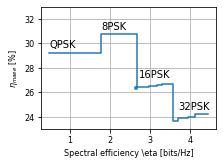

In [33]:
fig, ax = plt.subplots(1,1)
#modcod_df = modcod_df.sort_values('eta')

papr_db = 10*np.log10(modcod_df.papr)
#ax.step(modcod_df.eta, papr_db)
eta_papr = 0.5*10**(-papr_db/20)

ax.step(modcod_df.eta, eta_papr * 100)
ax.text(modcod_df.eta[0], eta_papr[0] * 100 + .4, 'QPSK')
ax.text(modcod_df.eta[11], eta_papr[11] * 100 + .4, '8PSK')
ax.text(modcod_df.eta[17] + 0.1, eta_papr[17] * 100 + 1, '16PSK')
ax.text(modcod_df.eta[23], eta_papr[23] * 100 + 1, '32PSK')

#ax.plot(papr)
# for i, row in modcod_df.iterrows():
#     ax.text(row.eta, row.maee, row.order_name + row.rate)

ax.set_ylim((23, 33))
ax.grid()
ax.set_ylabel('$\eta_{maee}$ [%]')
ax.set_xlabel('Spectral efficiency \eta [bits/Hz]')

from pyreport import PlotUtil
PlotUtil.apply_report_formatting()
plt.tight_layout()
plt.savefig('D:/git/thesis_report_ae/figures/papr_dvb_s2.pdf')

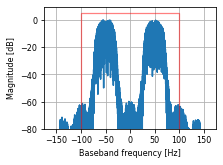

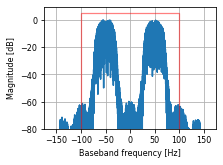

In [56]:
alpha = 0.35

B_Hz = 200e6
B_ch_Hz = 96e6

Rs_syms = 0.5 * B_ch_Hz / (1 + alpha)

upsample_factor = 2 * 4 # Must be at least 2 x (1+alpha)

fs_Hz = Rs_syms * upsample_factor # Baseband frequency

_, h_rrc = md.raised_root_cosine(upsample_factor, 3, alpha)

f0 = -B_Hz/4    # Sub-carriers
f1 = B_Hz/4

max_mod_order = np.max(modcod_df['order'])
N_sym = 1000 * max_mod_order
N_bit = N_sym * 2**max_mod_order

bit_seq0 = np.random.randint(0, 2, N_bit)
bit_seq1 = np.random.randint(0, 2, N_bit)

eta_maee = np.zeros(len(modcod_df))
papr = np.zeros(len(modcod_df))
EPD = np.zeros(len(modcod_df))

mag_list = [None] * len(modcod_df)
filt_sym_seq_list = [None] * len(modcod_df)

# Generate symbols
for i, row in modcod_df.iterrows():

    symbols, grey_mapping = md.generate_apsk_symbols(row)
    mod_order = int(np.log2(len(symbols)))

    seq_len = int((N_sym / 5) * mod_order * (2**mod_order))

    dt = 1/fs_Hz
    N_t = seq_len / mod_order * upsample_factor + len(h_rrc) - 1
    t = np.arange(0, N_t*dt, dt)

    sym_seq0 = md.modulate(symbols, grey_mapping, bit_seq0[:seq_len])
    filt_sym_seq0 = np.convolve(sym_seq0.repeat(upsample_factor), h_rrc)
    filt_sym_seq0 = filt_sym_seq0 / np.max(np.abs(filt_sym_seq0))
    filt_sym_seq0 = filt_sym_seq0 * np.exp(-1j * 2*np.pi * f0 * t)


    sym_seq1 = md.modulate(symbols, grey_mapping, bit_seq1[:seq_len])
    filt_sym_seq1 = np.convolve(sym_seq1.repeat(upsample_factor), h_rrc)
    filt_sym_seq1 = filt_sym_seq1 / np.max(np.abs(filt_sym_seq1))
    filt_sym_seq1 = filt_sym_seq1 * np.exp(-1j * 2*np.pi * f1 * t)

    filt_sym_seq_list[i] = filt_sym_seq0 + filt_sym_seq1
    filt_sym_seq_list[i] = filt_sym_seq_list[i] / np.max(filt_sym_seq_list[i])

# Plot spectrum
for i, row in modcod_df.loc[0:1].iterrows():
    y = np.fft.fft(filt_sym_seq_list[i])
    y = y / np.min(y)
    f = np.fft.fftfreq(len(y), d=1/fs_Hz)
    fig, ax = plt.subplots(1,1, figsize=(6.4, 2.4))

    y = np.fft.fftshift(y)
    f = np.fft.fftshift(f) / 1e6

    ax.set_xlim((-175, 175))
    ax.set_ylim((-80, 10))

    ax.set_xlabel('Baseband frequency [Hz]')
    ax.set_ylabel('Magnitude [dB]')

    ax.yaxis.set_ticks_position('left')

    ax.plot(f, 20*np.log10(np.abs(y)))
    ax.grid(True)

    PlotUtil.apply_report_formatting()

    import matplotlib
    rect = matplotlib.patches.Rectangle((-100, -85), 200, 90,
                                        linewidth=1.25, edgecolor='r', alpha=0.5, facecolor='none', zorder=99)
    ax.add_patch(rect)


    plt.tight_layout()
    plt.savefig('D:/git/thesis_report_ae/figures/spectrum_200MHz_%s.pdf' % row.label_string[:-1])
    plt.show()

VkVs = 0.12
a, Pdiss, gamma = maee.power_dissipation_profile(VkVs)

# Calculate metrics
for i, row in modcod_df.iterrows():

    filt_sym_seq = filt_sym_seq_list[i]

    # PAPR
    papr[i] = maee.papr(filt_sym_seq)

    # MAEE
    eta_maee[i] = maee.maee(filt_sym_seq, a, Pdiss)

modcod_df['maee_%d_200MHz' % int(VkVs * 100)] = eta_maee
modcod_df['papr_200MHz'] = papr
modcod_df['eta_200MHz'] = modcod_df.eta * 2 * B_ch_Hz / B_Hz

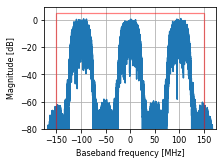

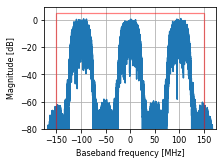

In [54]:
alpha = 0.35
B_Hz = 300e6
B_ch_Hz = 96e6

Rs_syms = 0.5 * B_ch_Hz / (1 + alpha)

upsample_factor = 3 * 4 # Must be at least 2 x (1+alpha)

fs_Hz = Rs_syms * upsample_factor # Baseband frequency

_, h_rrc = md.raised_root_cosine(upsample_factor, 3, alpha)

f0 = -B_Hz/3    # Sub-carriers
f1 = 0
f2 = B_Hz/3

max_mod_order = np.max(modcod_df['order'])
N_sym = 1000 * max_mod_order
N_bit = N_sym * 2**max_mod_order

bit_seq0 = np.random.randint(0, 2, N_bit)
bit_seq1 = np.random.randint(0, 2, N_bit)
bit_seq2 = np.random.randint(0, 2, N_bit)

eta_maee = np.zeros(len(modcod_df))
papr = np.zeros(len(modcod_df))
EPD = np.zeros(len(modcod_df))

mag_list = [None] * len(modcod_df)
filt_sym_seq_list = [None] * len(modcod_df)

# Generate symbols
for i, row in modcod_df.iterrows():

    symbols, grey_mapping = md.generate_apsk_symbols(row)
    mod_order = int(np.log2(len(symbols)))

    seq_len = int((N_sym / 5) * mod_order * (2**mod_order))

    dt = 1/fs_Hz
    N_t = seq_len / mod_order * upsample_factor + len(h_rrc) - 1
    t = np.arange(0, N_t*dt, dt)

    sym_seq0 = md.modulate(symbols, grey_mapping, bit_seq0[:seq_len])
    filt_sym_seq0 = np.convolve(sym_seq0.repeat(upsample_factor), h_rrc)
    filt_sym_seq0 = filt_sym_seq0 / np.max(np.abs(filt_sym_seq0))
    filt_sym_seq0 = filt_sym_seq0 * np.exp(-1j * 2*np.pi * f0 * t)

    sym_seq1 = md.modulate(symbols, grey_mapping, bit_seq1[:seq_len])
    filt_sym_seq1 = np.convolve(sym_seq1.repeat(upsample_factor), h_rrc)
    filt_sym_seq1 = filt_sym_seq1 / np.max(np.abs(filt_sym_seq1))
    filt_sym_seq1 = filt_sym_seq1 * np.exp(-1j * 2*np.pi * f1 * t)

    sym_seq2 = md.modulate(symbols, grey_mapping, bit_seq1[:seq_len])
    filt_sym_seq2 = np.convolve(sym_seq1.repeat(upsample_factor), h_rrc)
    filt_sym_seq2 = filt_sym_seq2 / np.max(np.abs(filt_sym_seq2))
    filt_sym_seq2 = filt_sym_seq2 * np.exp(-1j * 2*np.pi * f2 * t)

    filt_sym_seq_list[i] = filt_sym_seq0 + filt_sym_seq1 + filt_sym_seq2
    filt_sym_seq_list[i] = filt_sym_seq_list[i] / np.max(filt_sym_seq_list[i])

# Plot spectrum
for i, row in modcod_df.loc[0:1].iterrows():
    y = np.fft.fft(filt_sym_seq_list[i])
    y = y / np.min(y)
    f = np.fft.fftfreq(len(y), d=1/fs_Hz)
    fig, ax = plt.subplots(1,1, figsize=(6.4, 2.4))

    y = np.fft.fftshift(y)
    f = np.fft.fftshift(f) / 1e6

    ax.set_xlim((-175, 175))
    ax.set_ylim((-80, 10))

    ax.set_xlabel('Baseband frequency [MHz]')
    ax.set_ylabel('Magnitude [dB]')

    ax.yaxis.set_ticks_position('left')

    ax.plot(f, 20*np.log10(np.abs(y)))


    ax.grid(True)

    PlotUtil.apply_report_formatting()

    import matplotlib
    rect = matplotlib.patches.Rectangle((-150, -85), 300, 90,
                                        linewidth=1.25, edgecolor='r', alpha=0.5, facecolor='none', zorder=99)
    ax.add_patch(rect)

    plt.tight_layout()
    plt.savefig('D:/git/thesis_report_ae/figures/spectrum_300MHz_%s.pdf' % row.label_string[:-1])
    plt.show()

VkVs = 0.12
a, Pdiss, gamma = maee.power_dissipation_profile(VkVs)

# Calculate metrics
for i, row in modcod_df.iterrows():

    filt_sym_seq = filt_sym_seq_list[i]

    # PAPR
    papr[i] = maee.papr(filt_sym_seq)

    # MAEE
    eta_maee[i] = maee.maee(filt_sym_seq, a, Pdiss)

modcod_df['maee_%d_300MHz' % int(VkVs * 100)] = eta_maee
modcod_df['papr_300MHz'] = papr
modcod_df['eta_300MHz'] = modcod_df.eta * 3 * B_ch_Hz / B_Hz

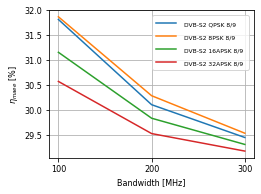

In [57]:
fig, ax = plt.subplots(1,1)
#modcod_df = modcod_df.sort_values('eta')

selection_df = modcod_df.loc[[9, 15, 21, 26]]

for i, row in selection_df.iterrows():

    maee_vals = np.array([row['maee_12'], row['maee_12_200MHz'], row['maee_12_300MHz']])
    bandwidth = [100, 200, 300]

    ax.plot(bandwidth, maee_vals * 100, label=row.label)

ax.grid(True)
ax.set_ylabel('$\eta_{maee}$ [%]')
ax.set_xlabel('Bandwidth [MHz]')

ax.set_xticks(bandwidth)
ax.legend()

PlotUtil.apply_report_formatting(3.73, 2.8)
plt.tight_layout()
plt.savefig('D:/git/thesis_report_ae/figures/carrier_aggr_maee.pdf')
plt.show()

In [36]:
modcod_df.to_pickle('dvbs2.pkl')